In [71]:


#This code was developed by Scott McCoy and Sophie Rothman


#Import
import numpy as np
from matplotlib import pyplot as plt
import math


In [72]:
#%% Setting time parameters
tf = 28000000              #final run time in Myr - 6000000
dt = 50                   #time step (yr)
ta = np.arange(0,tf,dt)   #array of times

In [73]:
#%% Model grid
L = 30e3 #63e3                  # river length [m]
zb = 0                          #base level of mainstem [m]
dx = 50                         #grid spacing
xc = 400                        #set critical distance from ridge to define rivers (ie where fluvial processes turn on [m]
x_d = np.arange(xc, (L), dx)    #build x array of distance from divide
Nnodes = len(x_d)               #Number of nodes


In [74]:
#%%
#Plotting Parameters
plotevery = 500000     #plot every so many yr-- started as 100,000 in the animation #it was 600000 for the figures 
saveevery = 500000      #save frames every so many yr - to be plotted back in time series of evolution


In [75]:
#%%%
#Set Stream Power Erosion Parameters
ka = 6.69          #hack coefficient
h = 1.8            #inverse hack exponent
K = 5e-7          #erodibility
n = 1  #1              #slope exponent
m = 0.45 #0.45           #drainage area exponent
theta = m/n        # channel concavity

In [97]:
#%% Set Uplift scheme
U=80e-6
Ufield = (np.ones(len(x_d))*U)   
Ufield[-1] = 0              #Holding the outlet at 0


#instituting a pulse of uplift
longpulse=1      #binary for whether you want to put in a pulse
Pulse=200         #magnitude of pulse in meters
PulseTime=500000 #years over which pulse occurs
PulseYear=Pulse/PulseTime   #magnitude of pulse per year
if longpulse:
    Upulse=U+PulseYear          #Uplift during pulse timesteps
    Ufieldpulse=np.ones(len(x_d))*Upulse
    Ufieldpulse[-1] = 0              #Holding the outlet at 0

maxkp_track=np.zeros((int(tf/plotevery),len(x_d)))
minkp_track=np.zeros((int(tf/plotevery),len(x_d)))


[8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05
 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05
 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05
 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05
 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05
 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05
 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05
 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05
 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05
 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05
 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05
 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05
 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05
 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05 8.e-05
 8.e-0

In [88]:
#%% Autogenic Waterfall Controls
waterfalls_ms =1            #turn on autogenic waterfalls in mainstem  - 0 turns them off
Fms = 0.5 #factor to change efficientcy of stream power rate -we use Fms=0.5 for slow waterfalls and Fms=2 for fast waterfalls
Sc = 0.05                     #Slope above which waterfalls are turned on
#Initial profile - one should have a 1, others 0
start_wf=1     # Initial profile is waterfall steady state (1)
start_ssp=0    # Initial profile is a standard stream power(1)


In [89]:
#%%%%
#Initializing other Parameters

t = 0       #initial time
iteration = 0

wfix_ms =np.zeros(Nnodes)  #Array for waterfall indices - determines whether you plot where waterfalls are on?
dzdx = np.zeros((Nnodes))
dzdx0=np.zeros((Nnodes))
dzdx2=np.zeros((Nnodes))
#wfpoints=np.zeros((len(ta), Nnodes))    ###FOR TRACKING LINEAR SECTION

dzdx_u=np.zeros((Nnodes))
dzdx0_u=np.zeros((Nnodes))
dzdx2_u=np.zeros((Nnodes))
z=np.zeros((Nnodes))
z0=np.zeros((Nnodes))
z2=np.zeros((Nnodes))
zwf=np.zeros((Nnodes))
z0_u=np.zeros((Nnodes))
z2_u=np.zeros((Nnodes))
zwf_u=np.zeros((Nnodes))
zwf = np.zeros((Nnodes))
dzdx_wf=np.zeros(Nnodes)

numsaved=np.int(tf/saveevery)
save_array_prof=np.zeros((numsaved, Nnodes))
save_array_dzdx=np.zeros((numsaved, Nnodes))
maxkp_track=np.zeros((int(tf/plotevery),len(x_d)))
minkp_track=np.zeros((int(tf/plotevery),len(x_d)))
savez=np.zeros((int(tf/plotevery),len(x_d)))
savecurve=np.zeros((int(tf/plotevery),len(x_d)))
knickzones=np.zeros((np.shape(minkp_track)))



C:\Users\soph1\AppData\Local\Temp\ipykernel_27420\2597857201.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numsaved=np.int(tf/saveevery)


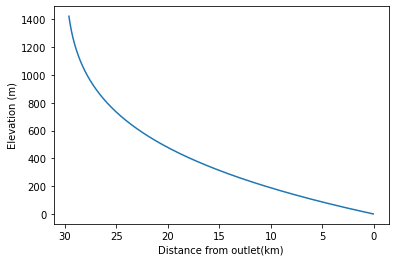

In [90]:
#%% Creating Standard Stream Power Steady State
z0[0:(Nnodes)] = (((U/K)**(1/n))*((ka**(-theta))/(1-(h*theta)))*(((L)**(1-(h*theta))) - (x_d[0:(Nnodes)]**(1-(h*theta)))))
    #slope
dzdx0[0:(Nnodes-1)] = (1/dx)*(z0[0:(Nnodes-1)] - z0[1:(Nnodes)])
zb=z0[-1]
plt.plot(30-x_d/1e3, z0)

plt.ylabel('Elevation (m)')
plt.xlabel('Distance from outlet(km)')
plt.gca().invert_xaxis()

C:\Users\soph1\AppData\Local\Temp\ipykernel_27420\155481380.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if len(x_d)> (np.int(((xcrit-xc)/dx))-1):
C:\Users\soph1\AppData\Local\Temp\ipykernel_27420\155481380.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the releas

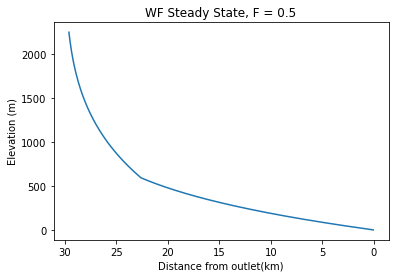

In [91]:
#%% Creating Waterfall Steady State

#Waterfall Effected Profile
    #elevation
z2[0:(Nnodes)] = (((U/(K*Fms))**(1/n))*((ka**(-theta))/(1-(h*theta)))*(((L)**(1-(h*theta))) - (x_d[0:(Nnodes)]**(1-(h*theta)))))
    #slope
dzdx2[0:(Nnodes-1)] = (1/dx)*(z2[0:(Nnodes-1)] - z2[1:(Nnodes)]) 

#The points at which the profile switches between F=1 and F=Fwf
xcrit_2=(((U/(K*Fms*(ka**m)))**(1/(h*m)))*((1/Sc)**(n/(h*m))))
xcrit=(((U/(K*(ka**m)))**(1/(h*m)))*((1/Sc)**(n/(h*m))))

#Find the elevation at xcrit
if len(x_d)> (np.int(((xcrit-xc)/dx))-1):
    zcrit= (((U/K)**(1/n))*((ka**(-theta))/(1-(h*theta)))*(((L)**(1-(h*theta))) - (x_d[(np.int(((xcrit-xc)/dx))-1)]**(1-(h*theta)))))
else:
    print('xcrit occurs farther from the divide than length')
    

#Putting together the profiles for a slow waterfall
if Fms<=1:
    for i in range(np.int(((xcrit-xc)/dx))+1, (Nnodes-1)):
        zwf[i]=z0[i]
        dzdx_wf[i]=dzdx0[i]
        
    for i in range(0, (np.int((xcrit-xc)/dx))+1):
        zwf[i]=z2[i]-z2[np.int((xcrit-xc)/dx)+1]+zwf[np.int((xcrit-xc)/dx)+1]
        dzdx_wf[i]=dzdx2[i]

#creating the fast waterfall profile takes the extra step of finding x_crit2 
#and z_crit2
#FAST WATERFALLS

if Fms>1:
    xcrit_2=(((U/(K*Fms*(ka**m)))**(1/(h*m)))*((1/Sc)**(n/(h*m))))
    zcrit2=z0[np.int((xcrit-xc)/dx)]+(Sc*(xcrit-xcrit_2))
    
    for i in range(np.int(((xcrit-xc)/dx)), (Nnodes)):
        zwf[i]=z0[i]
        dzdx_wf[i]=dzdx0[i]
    
    for i in range((np.int((xcrit_2-xc)/dx)), (np.int((xcrit-xc)/dx))):
        zwf[i]=(zwf[(np.int((xcrit-xc)/dx))]+((x_d[(np.int((xcrit-xc)/dx))]-x_d[i])*Sc))
        dzdx_wf[i]=Sc

    for i in range(0,(np.int((xcrit_2-xc)/dx))):
        zwf[i]=(z2[i]-z2[np.int((xcrit_2-xc)/dx)] + zwf[np.int((xcrit_2-xc)/dx)])
        dzdx_wf[i]=dzdx2[i]
plt.plot(30-x_d/1e3, zwf)
plt.title('WF Steady State, F = '+ str(Fms))
plt.ylabel('Elevation (m)')
plt.xlabel('Distance from outlet(km)')
plt.gca().invert_xaxis()
  

C:\Users\soph1\AppData\Local\Temp\ipykernel_27420\2818793046.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


<Figure size 1296x936 with 0 Axes>

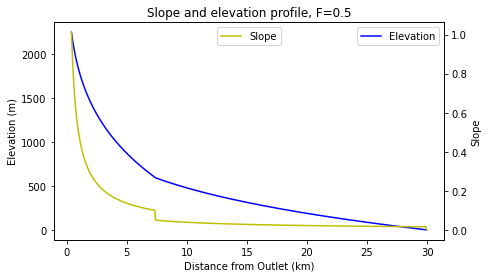

In [92]:
#%%% setting the initial profile depending on choices, plotting initial profile
if start_wf:
    z=np.copy(zwf)
    dzdx=np.copy(dzdx_wf)
if start_ssp:
    z=z0
    dzdx=dzdx0

fig1=plt.figure(figsize=(18,13))
fig1, (ax1)= plt.subplots(figsize=(7, 4),nrows=1, ncols=1)

ax1.set_xlabel('Distance from Outlet (km)')
ax1.set_title('Slope and elevation profile, F='+str(Fms))
ax1.plot((x_d/1e3), zwf, 'b-', label='Elevation')
ax1.set_ylabel('Elevation (m)')
#ax1.plot(xcrit/1e3, zcrit, 'ro')
    #ax1.plot(xcrit_2/1e3, zcrit2, 'yo')

ax11=ax1.twinx() 
ax11.plot( (x_d/1e3),dzdx_wf, 'y-', label='Slope')      ####Plots both elevation and slope
ax11.set_ylabel('Slope')
ax1.get_shared_x_axes().join(ax1, ax11) ####or ax2=ax1.twinx()
ax1.legend()
    #ax1.set_ylim(0,3000)
    #ax11.set_ylim(0,0.9)
ax11.legend(loc='upper center')
fig1.show()

Text(0.5, 1.0, 'Chi plot F=0.5')

<Figure size 432x288 with 0 Axes>

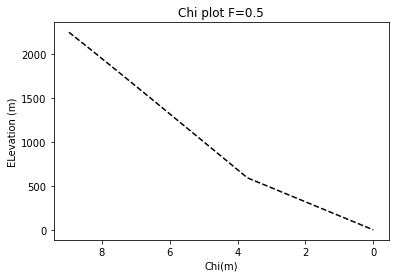

In [93]:
#%% Making Chi
A = ka*x_d**h    # calculate drainage area using Hack's law, which is formulated as a function of distance from the divide
A_sfo = np.flip(A)  # make first element of A be area at outlet
chi = dx * np.cumsum(A_sfo**(-theta)) #calculate chi at each stream node by integrating upstream from baselevel, which is why must flip A so A(1) is area at outlet
tau=dx*np.cumsum((1/K)*(A_sfo**(-m)))
chi=np.flip(chi)

fig1=plt.figure()
fig1, (ax3)=plt.subplots(figsize=(6, 4),nrows=1, ncols=1)
ax3.plot(chi, z, 'k--')
ax3.set_xlabel('Chi(m)')
ax3.set_ylabel('ELevation (m)')
ax3.invert_xaxis()
ax3.set_title('Chi plot F=' + str(Fms))

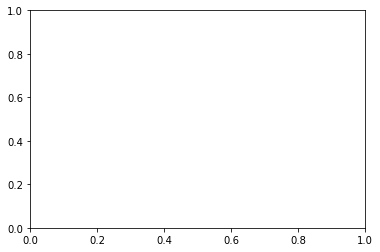

<Figure size 648x144 with 0 Axes>

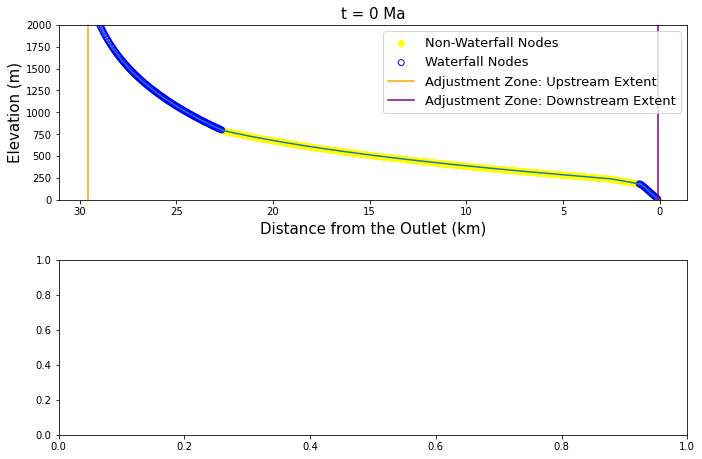

<Figure size 648x144 with 0 Axes>

Error in callback <function flush_figures at 0x000002455F554310> (for post_execute):



KeyboardInterrupt



In [98]:



E_total=np.zeros(len(x_d))
E=np.zeros(len(x_d))
plotted=0

#RUNNING THE NUMERICAL MODEL
counter=0
from IPython.display import display, clear_output
savednum=0
for iiii in range (1, len(ta)):    #len(ta)
        #For plotting a time series of    
    if (math.remainder(ta[iiii],saveevery)==0):
        save_array_prof[savednum, :]=z
        save_array_dzdx[savednum, :]=dzdx
        savednum=savednum+1
    if (math.remainder(ta[iiii],plotevery)==0): #plot initial condition and then every plotevery iterations
        plotted=plotted+1
        plt.cla()
        fig1=plt.figure(figsize=(9,2))
        fig1, (ax1, ax3)= plt.subplots(figsize=(10, 7),nrows=2, ncols=1)
        fig1.patch.set_facecolor('white')#'xkcd:mint green')
        #fig2, (ax3)=plt.subplots(figsize=(8, 4), nrows=1, ncols=1)
        
        savez[counter,:]=z
        E_total=E_total+E*dt
       
        w = 50    #number of points to fit  polynomial to
        l = len(z)  #length of profile
        curvature=np.zeros(l) #initialize vector for hill top laplacian
        for ic in range(int(w/2+1), int(l-(w/2))): #  % center point index of point centered window
            xhh =x_d[int(ic-w/2):int(ic+w/2)]
            yp = z[int(ic-w/2):int(ic+w/2)]
            p = np.polyfit(xhh,yp,2) # %fit a second order polynomial to points in moving window
                            ###differentiate twice
            kpp = np.polyder(p)
            curvature[ic] = np.polyder(kpp) #hilltop laplacian
        
        savecurve[counter,:]=curvature

        ##########################################
        #if Fms<1:
           # fdzdx=np.genfromtxt(fname='slowwfdzdx_numss.txt')
        if Fms>1:
            fdzdx=dzdx_wf
        kz=np.logical_or((dzdx>1.05*fdzdx), (dzdx<.95*fdzdx))


        knickzones[counter,:]=kz 
        if len(x_d[kz])>2:
            kz1=np.where(kz>0)[0][1]
            kzend=np.where(kz>0)[0][-1]
        
        
        #plotting active waterfall sites
        if waterfalls_ms:
            v=0
            wfix_x=np.zeros(Nnodes)
            wfix_z=np.zeros(Nnodes)
            wfix_dzdx=np.zeros(Nnodes)
            wfix_dzdx_avg=np.zeros(Nnodes)
            dzdx_avg=np.zeros(Nnodes)
            for i in range(10,Nnodes-10):
                dzdx_avg[i]=np.average(dzdx[(i-10):(i+10)])
            for gg in range(0,len(dzdx)):
                if dzdx[gg]>Sc:
                    wfix_x[v]=x_d[gg]
                    wfix_z[v]=z[gg]
                    wfix_dzdx[v]=dzdx[gg]
                    wfix_dzdx_avg[v]=dzdx_avg[gg]
                    v=v+1

               
            ax1.set_xlabel('Distance from the Outlet (km)', size='15')
            ax1.set_ylabel('Elevation (m)', size='15')
            ax1.plot((30-(x_d/1e3)), z)
            #ax1.plot(x_d/1e3, fz, 'k--', label='Initial steady state')
            ax1.scatter((30-x_d[dzdx<Sc]/1e3), z[dzdx<Sc], edgecolor='yellow', facecolor='yellow', label='Non-Waterfall Nodes')
            ax1.scatter((30-x_d[dzdx>Sc]/1e3), z[dzdx>Sc], edgecolor='blue', facecolor='none', label='Waterfall Nodes')
            ax1.set_ylim(0,2000)
            ax1.invert_xaxis()
            ax1.set_title('t = ' + str(int(ta[iiii]/1e6))+ ' Ma', fontsize='15')
            if len(x_d[kz])>2:
                ax1.axvline(x=(30-x_d[kz1]/1e3), color='orange', label='Adjustment Zone: Upstream Extent')
                ax1.axvline(x=(30-x_d[kzend]/1e3), color='purple', label='Adjustment Zone: Downstream Extent')
                ax3.axvline(x=(30-x_d[kz1]/1e3), color='orange')
                ax3.axvline(x=(30-x_d[kzend]/1e3), color='purple')
                

            #ax1.text (0.05, .8,'t = ' + str(ta[i]/1e6)+ ' Ma',horizontalalignment='center', verticalalignment='center',transform = ax1.transAxes, fontsize=15) 

            ax3.plot( 30-(x_d/1e3),dzdx, 'k:')
           # ax3.plot(x_d/1e3, fdzdx, 'k--', label='Initial steady state')

            ax3.scatter(30-(x_d[dzdx<Sc]/1e3), dzdx[dzdx<Sc], edgecolor='yellow', facecolor='yellow', label='Non-Waterfall Nodes')
            ax3.scatter(30-(wfix_x/1e3), wfix_dzdx, edgecolor='blue', facecolor='none', label='Waterfall Nodes')
            ax3.invert_xaxis()
            ax3.set_xlabel('Distance from the Outlet (km)', size='15')
            ax3.set_ylabel('Slope', size='15')
            #ax3.set_xlim(3,25)
            ax3.set_ylim(0, .25)
            ax3.text (0.05, .17,'Sc',horizontalalignment='center', verticalalignment='center',transform = ax3.transAxes, fontsize=15) 
            ax3.plot((x_d/1e3), (np.ones(Nnodes)*Sc), color='#808080', linestyle='-')
            ax1.legend(loc='upper right', fontsize='13') 
            #ax3.plot( (x_d/1e3),dzdx_wf, 'y-', label='pre-pulse steady state')
            fig1.tight_layout(pad=1)



        if not waterfalls_ms:
            ax3.plot( (x_d/1e3),dzdx, 'y-', label='numerical solution')
            
        #fig1.savefig('thirdplot'+ str(counter)+'.png')
        counter=counter+1
        fig1.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
        
        plt.tight_layout(pad=2)
        display(fig1) # these are the two lines you need for the animation
        clear_output(wait=True)  
    
        
        
    #For plotting a time series of    
   # if (math.remainder(ta[i],saveevery)==0):
   #     save_array_prof[savednum, :]=z
   #     save_array_dzdx[savednum, :]=dzdx
   #     savednum=savednum+1

    dzdx[0:(Nnodes-1)] = (1/dx)*(z[0:(Nnodes-1)] - z[1:(Nnodes)]) 

    negslope=dzdx[dzdx<0]
    if len(negslope)>=1:
        print('negative slope')
        print(negslope)
        #break
    dzdx[(Nnodes-1)]=0
    z[Nnodes-1]=zb
    zold = z
    E = K * A**m * dzdx**n


    #For tracking where the waterfalls are in the linear section over time
    if waterfalls_ms:
        #wfix_ms = find(dzdx>Sc)        #get index of nodes that have waterfal
        E[dzdx>Sc] = Fms*E[dzdx>Sc]
        #wfpoints[i,:]=dzdx>Sc
    Utot=Ufield
    if longpulse:
        if ta[iiii]<PulseTime:
            Utot=Ufieldpulse


        #for jjj in range (0, len(ta)):
            #if dzdx[jjj]>Sc:
            #    wfpoints[i, jjj]=1
            #else:
            #    wfpoints[i, jjj]=0
                
        #wfpoints[i,:]=x_d[dzdx>Sc]
        #wfpoints=np.zeros((np.int(tf/dt), Nnodes))
        
        
        
        #Use Ufield_array to step change the uplift

    z = z + (Utot - E)*dt                 #update new elevations


    
    